**Image Reconstruction using Matrix Factorization and Linear Regression with RFF**

Importing Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import os
from einops import rearrange
from sklearn import preprocessing

Processing Functions

In [2]:
def mask_image_patch(img,x,y,z,patch_size):
    img_copy = img.clone()
    for i in range(patch_size):
        for j in range(patch_size):
                for k in range(z):
                    img_copy[x+i][y+j][k] = torch.nan
    return img_copy


def create_mask(t,x,y,patch_size):
    mask = torch.full(t.shape,True)
    z = t.shape[2]
    for i in range(patch_size):
        for j in range(patch_size):
                for k in range(z):
                    mask[x+i][y+j][k] = False
    return mask

def create_coordinate_map(img):
    height, width, num_channels = img.shape
    X = torch.empty((img.shape[0],img.shape[1],2))
    
    for i in range(height):
        for j in range(width):
            X[i][j][0] = i
            X[i][j][1] = j
    return X.reshape(-1,2)

def stack_itself(t, n):
    stacked_t = t.unsqueeze(1).expand(-1, n, -1)
    return stacked_t.squeeze()

def scale(img):
    img_flatted = img.reshape(-1,1)
    scaler_X = preprocessing.MinMaxScaler().fit(img_flatted)
    img_scaled = scaler_X.transform(img_flatted).reshape(img.shape)
    img_scaled = torch.tensor(img_scaled)
    img_scaled = img_scaled.float()
    return img_scaled


Creating Dataset

In [3]:
img = torchvision.io.read_image('dog.jpg')
img_scaled = scale(img)
cropped_img = torchvision.transforms.functional.crop(img_scaled,600,800,300,300)
cropped_img = rearrange(cropped_img,'c h w -> h w c')
cropped_img = torch.tensor(cropped_img,dtype = torch.float32)
original_img = cropped_img.clone()

Processing Functions

Matrix Factorization

In [22]:
def factorize_matrix(A, r):
    mask = ~torch.isnan(A)
    m,n = A.shape
    W = torch.rand(m,r,requires_grad=True)
    H = torch.rand(r,n,requires_grad=True)
    optimizer = optim.Adam([W,H],lr = 0.01)

    max_epochs = 1000
    for i in range(max_epochs):
        loss = torch.norm((A - torch.mm(W,H))[mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return W,H, loss

def image_reconstrunction_matrix_factorization(original_img, masked_img, patch_size):
    W,H,loss = factorize_matrix(rearrange(masked_img, 'h w c -> h (w c)'), 50)
    reconstructed_img = torch.mm(W,H).detach()
    reconstructed_img = reconstructed_img.reshape(masked_img.shape[0],masked_img.shape[1],masked_img.shape[2])
    mask = torch.isnan(masked_img)

    # reconstructed_img = scale(reconstructed_img)
    
    fig,axs = plt.subplots(2,2)
    axs[0][0].imshow(masked_img)
    axs[0][1].imshow(reconstructed_img)
    axs[1][0].imshow(original_img[mask].reshape(patch_size,patch_size,3))
    axs[1][1].imshow(reconstructed_img[mask].reshape(patch_size,patch_size,3))
    plt.show()
    return reconstructed_img

Linear Regression + RFF

In [30]:
def plot_reconstructed_and_original_image(original_img, masked_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    height, width, num_channels = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X).reshape(height,width,num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(outputs)
    ax0.set_title("Reconstructed Image")
    
    ax1.imshow(original_img.cpu())
    ax1.set_title("Original Image")

    ax2.imshow(masked_img.cpu())
    ax2.set_title("Masked Image")

    
    for a in [ax0, ax1, ax2]:
        a.axis("off")
    plt.show()
    return outputs

def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (known_pixels, 2) // (x,y)
    Y: torch.Tensor of shape (known_pixels, 3) // (r,g,b)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    outputs = net(X)
    loss = criterion(outputs, Y)
    if verbose :
            print(f"Initial loss: {loss.item():.6f}")
            verbose = 2
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
    if verbose :
        print(f"Final loss: {loss.item():.6f}")
    return loss.item()


class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    

def image_reconstrunction_linear_rff(original_img,masked_img):
    
    y = original_img.clone().reshape(-1,3)
    X = create_coordinate_map(original_img)
    mask = ~torch.isnan(masked_img).reshape(-1,3)
    X_train = X[mask[:,0:2]].reshape(-1,2)
    y_train = y[mask].reshape(-1,3)

    # Without RFF
    # net = LinearModel(2,3)
    # train(net,0.01,X_train,y_train,1000)
    # plot_reconstructed_and_original_image(original_img, net, X, title="Reconstructed Image")

    # With RFF
    X_rff = create_rff_features(X, 100, 0.008)
    mask_rff = stack_itself(mask[:,0].unsqueeze(1),100)
    X_rff_train = X_rff[mask_rff].reshape(-1,100)
    y_rff_train = y[mask].reshape(-1,3)

    netrff = LinearModel(X_rff_train.shape[1], 3)
    train(netrff, 0.005, X_rff_train, y_rff_train, 1000)
    reconstructed_img = plot_reconstructed_and_original_image(original_img, masked_img, netrff, X_rff, title="Reconstructed Image with RFF Features")
    return reconstructed_img

Metrics

In [47]:
def mse(original_img,reconstructed_img):
    mse = []
    for i in range(3):
        mse.append(nn.functional.mse_loss(original_img[:,:,0],reconstructed_img[:,:,0]))
    return mse

In [48]:
def psnr(original_img,reconstructed_img):
    psnr = []
    for i in range(3):
        maxi = torch.max(original_img[:,:,i])
        mse = nn.functional.mse_loss(original_img[:,:,0],reconstructed_img[:,:,0])
        psnr.append(20*torch.log10(maxi/mse))
    return psnr

Reconstructions

A. 1 color patch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


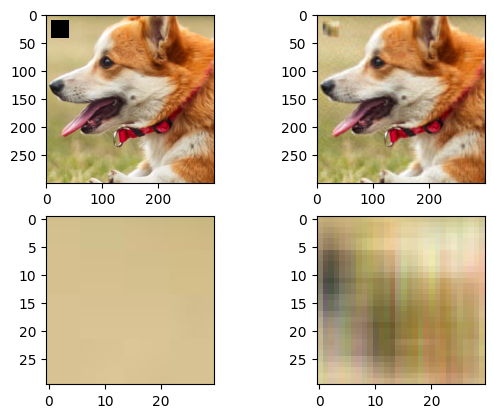

B. 2 color patch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


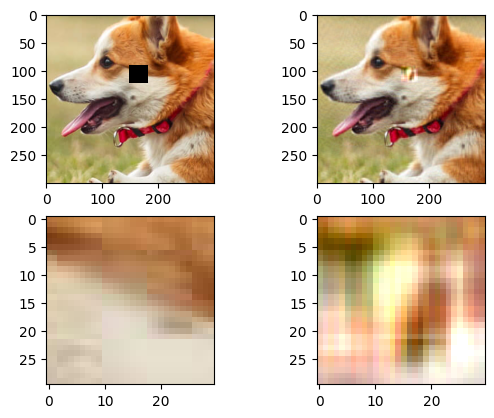

C. 5 color patch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


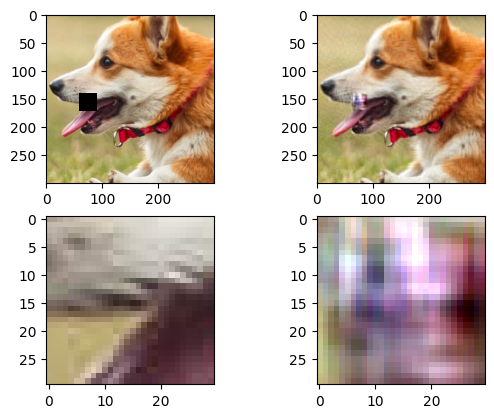

In [36]:
patch_size = 30
x_y_s = [[10,10,3],[90,150,3],[140,60,3]]
titles = ["A. 1 color patch", "B. 2 color patch", "C. 5 color patch"]
reconstructed_images_1 = []

for i in range(len(x_y_s)):
    print(titles[i])
    masked_img = mask_image_patch(original_img,x_y_s[i][0],x_y_s[i][1],3,patch_size)
    reconstructed_images_1.append(image_reconstrunction_matrix_factorization(original_img,masked_img,patch_size))

Patch Size  : 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


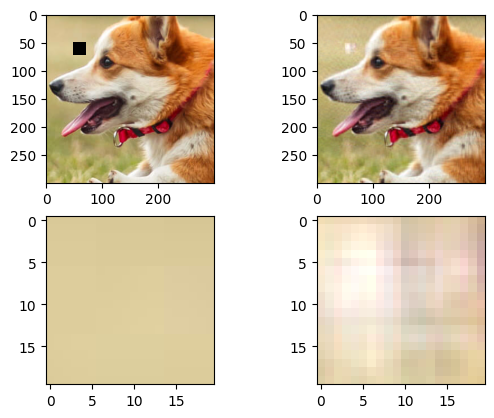

Patch Size  : 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


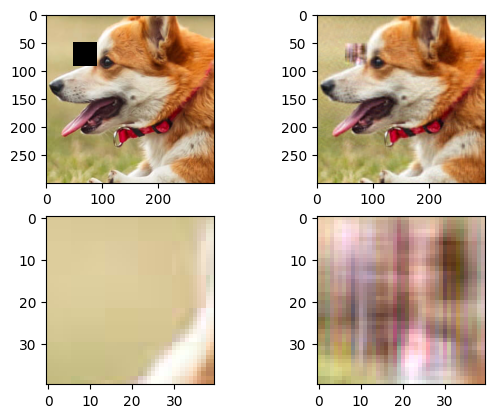

Patch Size  : 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


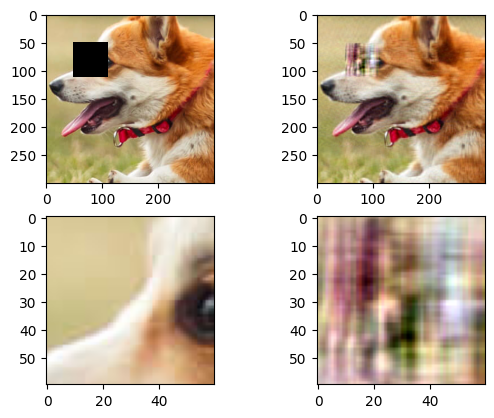

Patch Size  : 80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


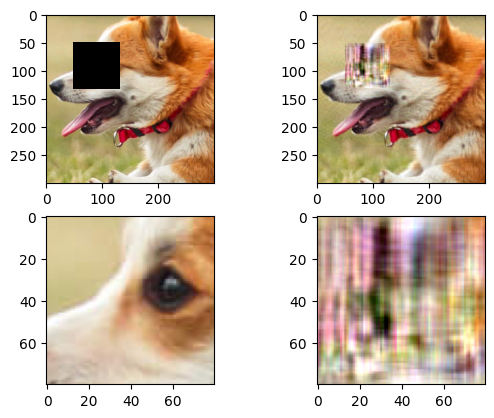

Patch Size  : 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


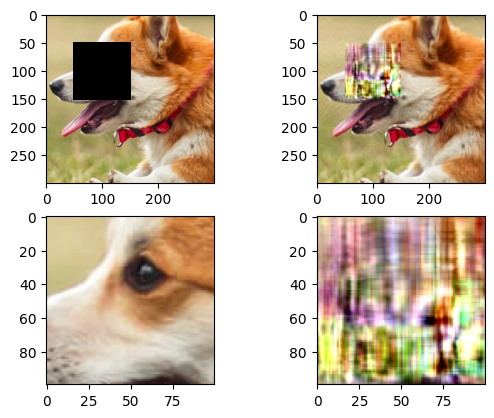

In [51]:
x_start = 50
y_start = 50
# n1 = [30]
patch_sizes = [20,40,60,80,100]
reconstructed_images_2 = []

for i in range(len(patch_sizes)):
    print(f"Patch Size  : {patch_sizes[i]}")
    masked_img = mask_image_patch(original_img,x_start,y_start,3,patch_sizes[i])
    reconstructed_images_2.append(image_reconstrunction_matrix_factorization(original_img,masked_img,patch_sizes[i]))

Initial loss: 0.454827
Final loss: 0.040596


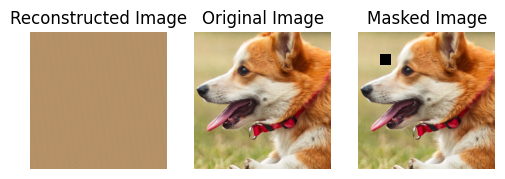

Initial loss: 0.364066
Final loss: 0.040472


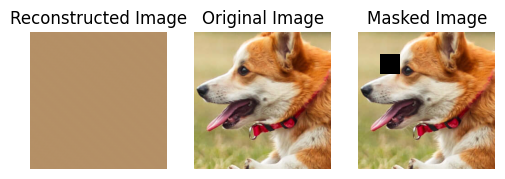

Initial loss: 0.431258
Final loss: 0.039623


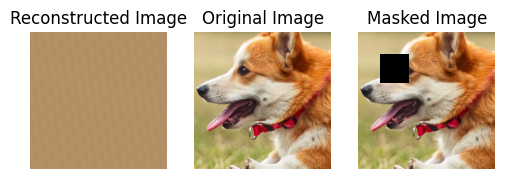

Initial loss: 0.321999
Final loss: 0.038776


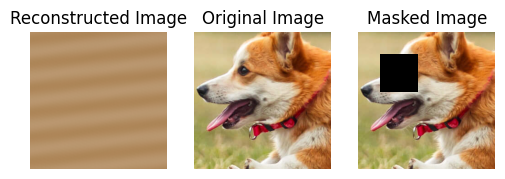

Initial loss: 0.341952
Final loss: 0.039308


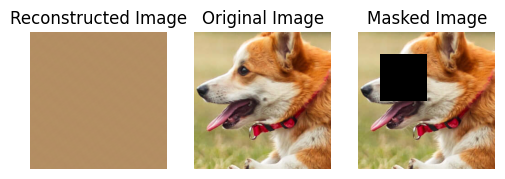

In [33]:
x_start = 50
y_start = 50
# n1 = [30]
patch_sizes = [20,40,60,80,100]
reconstructed_images_3 = []
for i in range(len(patch_sizes)):
    masked_img = mask_image_patch(original_img,x_start,y_start,3,patch_sizes[i])
    reconstructed_images_3.append(image_reconstrunction_linear_rff(original_img,masked_img))

Initial loss: 0.418809
Final loss: 0.040741


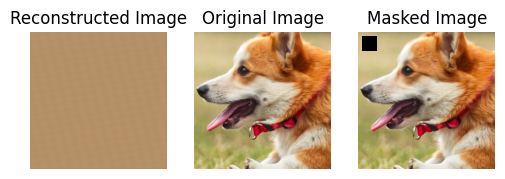

Initial loss: 0.377722
Final loss: 0.040562


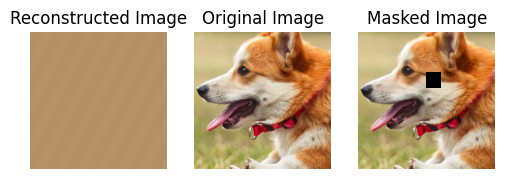

Initial loss: 0.394149
Final loss: 0.040446


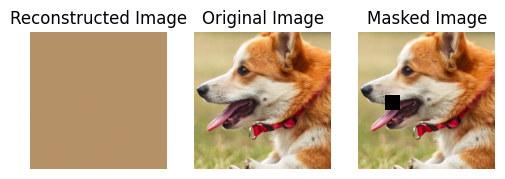

In [34]:
patch_size = 30
x_y_s = [[10,10],[90,150],[140,60]]
reconstructed_images_4 = []
for i in range(len(x_y_s)):
    masked_img = mask_image_patch(original_img,x_y_s[i][0],x_y_s[i][1],3,patch_size)
    reconstructed_images_4.append(image_reconstrunction_linear_rff(original_img,masked_img))

Performance

In [50]:
# Matrix factorization on 30*30 patch

titles = ["A. 1 color patch", "B. 2 color patch", "C. 5 color patch"]
for i in range(len(reconstructed_images_1)):
    print(titles[i])
    print("MSE : ",mse(original_img, reconstructed_images_1[i]))
    print("PSNR : ",psnr(original_img, reconstructed_images_1[i]))

A. 1 color patch
MSE :  [tensor(0.0010), tensor(0.0010), tensor(0.0010)]
PSNR :  [tensor(60.2432), tensor(60.2432), tensor(60.2432)]
B. 2 color patch
MSE :  [tensor(0.0010), tensor(0.0010), tensor(0.0010)]
PSNR :  [tensor(60.4333), tensor(60.4333), tensor(60.4333)]
C. 5 color patch
MSE :  [tensor(0.0011), tensor(0.0011), tensor(0.0011)]
PSNR :  [tensor(59.2467), tensor(59.2467), tensor(59.2467)]


In [52]:
# Matrix factorization on N*N patch

titles = [20,40,60,80,100]
for i in range(len(reconstructed_images_2)):
    print("N : ",titles[i])
    print("MSE : ",mse(original_img, reconstructed_images_2[i]))
    print("PSNR : ",psnr(original_img, reconstructed_images_2[i]))

N :  20
MSE :  [tensor(0.0006), tensor(0.0006), tensor(0.0006)]
PSNR :  [tensor(64.3643), tensor(64.3643), tensor(64.3643)]
N :  40
MSE :  [tensor(0.0014), tensor(0.0014), tensor(0.0014)]
PSNR :  [tensor(57.3450), tensor(57.3450), tensor(57.3450)]
N :  60
MSE :  [tensor(0.0039), tensor(0.0039), tensor(0.0039)]
PSNR :  [tensor(48.1430), tensor(48.1430), tensor(48.1430)]
N :  80
MSE :  [tensor(0.0055), tensor(0.0055), tensor(0.0055)]
PSNR :  [tensor(45.1808), tensor(45.1808), tensor(45.1808)]
N :  100
MSE :  [tensor(0.0090), tensor(0.0090), tensor(0.0090)]
PSNR :  [tensor(40.9559), tensor(40.9559), tensor(40.9559)]


In [53]:
# LRFF on 30*30 patches

titles = ["A. 1 color patch", "B. 2 color patch", "C. 5 color patch"]
for i in range(len(reconstructed_images_3)):
    print(titles[i])
    print("MSE : ",mse(original_img, reconstructed_images_3[i]))
    print("PSNR : ",psnr(original_img, reconstructed_images_3[i]))

A. 1 color patch
MSE :  [tensor(0.0287), tensor(0.0287), tensor(0.0287)]
PSNR :  [tensor(30.8379), tensor(30.8379), tensor(30.8379)]
B. 2 color patch
MSE :  [tensor(0.0287), tensor(0.0287), tensor(0.0287)]
PSNR :  [tensor(30.8355), tensor(30.8355), tensor(30.8355)]
C. 5 color patch
MSE :  [tensor(0.0287), tensor(0.0287), tensor(0.0287)]
PSNR :  [tensor(30.8344), tensor(30.8344), tensor(30.8344)]


In [54]:
# LRFF on N*N patch

titles = [20,40,60,80,100]
for i in range(len(reconstructed_images_4)):
    print("N : ",titles[i])
    print("MSE : ",mse(original_img, reconstructed_images_4[i]))
    print("PSNR : ",psnr(original_img, reconstructed_images_4[i]))

N :  20
MSE :  [tensor(0.0287), tensor(0.0287), tensor(0.0287)]
PSNR :  [tensor(30.8394), tensor(30.8394), tensor(30.8394)]
N :  40
MSE :  [tensor(0.0287), tensor(0.0287), tensor(0.0287)]
PSNR :  [tensor(30.8402), tensor(30.8402), tensor(30.8402)]
N :  60
MSE :  [tensor(0.0287), tensor(0.0287), tensor(0.0287)]
PSNR :  [tensor(30.8383), tensor(30.8383), tensor(30.8383)]


Increase RFF from 100 to 37500 in create_rff_features function !!